# MESSI Cluster Analysis

This notebook improves feature engineering & re-runs cluster analysis. 

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from IPython.display import display
sns.set_theme() # changes more defaults

## Data Import

In [16]:
# data import
tmp_ftrs_old = pd.read_csv("../data/tmp_ftrs.csv")
messi_loc = pd.read_csv("../data/messi_location_clean.csv")
tmp_raw = pd.read_csv("../data/tmp.csv", parse_dates=[0], low_memory=False)

## Feature Engineering

Folgende Parameter wurden bereits im notebook #1 berechnet und werden importiert:
- Differenz der Tageshöchst- und tiefstwerte $  \Delta T_{max} - \Delta T_{min} $ 
- Arithmetisches Mittel $  \overline{\Delta T} $
- Standardabweichung $  \sigma  \Delta T $
- Altitude

Als neue Parameter werden berechnet:
- Mittelwert und Standardabweichung der MESSI-Temperaturwerte (ohne Abweichung vom dwd-Tagesmittel)
- (Mittlere) Abweichung vom dwd-Mittel *für jeden Zeitschritt*, d. h. keine dwd-Tagesmitteltemperatur

In [28]:
# mean
tmp_ftrs_new = (tmp_raw
    [tmp_raw.origin == "messi"]
    .groupby(["day", "id"], as_index=False)
    ["tmp"].mean()
    .rename(columns={"tmp": "mean"})
)

# std
tmp_ftrs_new["std"] = (tmp_raw
    [tmp_raw.origin == "messi"]
    .groupby(["day", "id"])
    ["tmp"].std()
    .values
)

# deviation from dwd-mean
dwd_mean = (tmp_raw
    [tmp_raw.origin == "dwd"]
    .groupby("time_measured", as_index=False)
    ["tmp"].mean()
    .rename(columns={"tmp": "dwd_mean"})
)

messi_dev = (tmp_raw
    [tmp_raw.origin == "messi"]
    .merge(right=dwd_mean, on="time_measured")
)

messi_dev["dev"] = messi_dev["tmp"] - messi_dev["dwd_mean"]

tmp_ftrs_new["dev"] = (messi_dev
    .groupby(["day", "id"])
    ["dev"].mean()
    .values
)

tmp_ftrs_new

,day,id,mean,std,dev
0,1,2,21.287037,2.018889,0.680556
1,1,8,21.518014,2.091451,0.832730
2,1,9,NaN,NaN,NaN
3,1,13,NaN,NaN,NaN
4,1,17,21.904618,1.485958,1.225278
...,...,...,...,...,...
987,31,74,18.489000,3.603771,1.489476
988,31,80,18.212664,3.568107,1.232372
989,31,85,NaN,NaN,NaN
990,31,88,19.093776,3.760315,1.387993


In [33]:
# joining "old" and "new" features
tmp_ftrs = pd.merge(
    left=tmp_ftrs_new,
    right=tmp_ftrs_old,
    how="inner",
    on=["day", "id"],
    suffixes=(None, "_dev")
).drop(columns=["dmin", "dmax"])

tmp_ftrs

,day,id,mean,std,dev,alt,diff,mean_dev,std_dev,nans
0,1,2,21.287037,2.018889,0.680556,42.0,7.810,0.607697,2.018889,36
1,1,8,21.518014,2.091451,0.832730,34.0,11.220,0.838674,2.091451,3
2,1,9,NaN,NaN,NaN,72.0,NaN,NaN,NaN,144
3,1,13,NaN,NaN,NaN,52.0,NaN,NaN,NaN,144
4,1,17,21.904618,1.485958,1.225278,34.0,6.180,1.225278,1.485958,0
...,...,...,...,...,...,...,...,...,...,...
987,31,74,18.489000,3.603771,1.489476,42.0,12.220,1.449417,3.603771,4
988,31,80,18.212664,3.568107,1.232372,40.0,12.075,1.173081,3.568107,7
989,31,85,NaN,NaN,NaN,72.0,NaN,NaN,NaN,144
990,31,88,19.093776,3.760315,1.387993,44.0,13.530,2.054192,3.760315,46


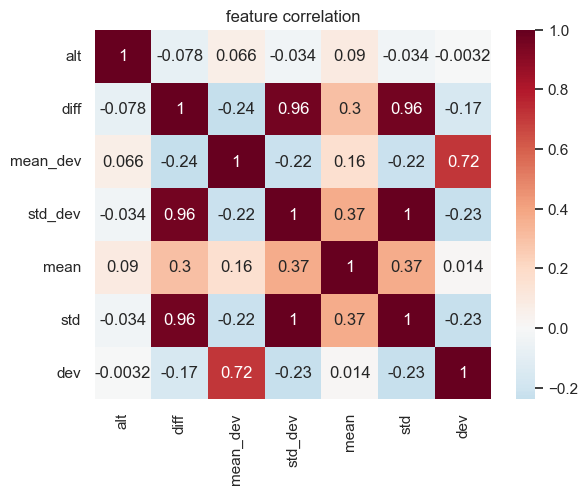

In [45]:
cols = ["alt", "diff", "mean_dev", "std_dev", "mean", "std", "dev"]

# .corr() method computes pairwise correlation of columns
data = tmp_ftrs[cols].corr(method="pearson")

fig, ax = plt.subplots()
sns.heatmap(data=data, annot=True, cmap="RdBu_r", center=0.0, ax=ax)
ax.set_title("feature correlation");
#fig.savefig("../figs/.png", dpi=300, bbox_inches="tight")

Überraschenderweise korrelieren die beiden Mittelwerte wenig. Kann das daran liegen, dass `mean_dev` negative Werte besitzt?

In [62]:
# standardize features by removing the mean and scaling to unit variance
# https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler
scaler = StandardScaler()
tmp_ftrs_scaled = pd.DataFrame(
    scaler.fit_transform(tmp_ftrs[cols]),
    columns=cols, index=tmp_ftrs.index
).merge(
    right=tmp_ftrs[["day", "id", "nans"]],
    left_index=True, right_index=True  
)
tmp_ftrs_scaled

,alt,diff,mean_dev,std_dev,mean,std,dev,day,id,nans
0,-0.263605,-1.202106,0.125202,-1.292880,-0.246605,-1.292880,0.224301,1,2,36
1,-1.057523,-0.555896,0.301644,-1.253173,-0.167880,-1.253173,0.383006,1,8,3
2,2.713586,NaN,NaN,NaN,NaN,NaN,NaN,1,9,144
3,0.728792,NaN,NaN,NaN,NaN,NaN,NaN,1,13,144
4,-1.057523,-1.510999,0.596967,-1.584504,-0.036113,-1.584504,0.792398,1,17,0
...,...,...,...,...,...,...,...,...,...,...
987,-0.263605,-0.366392,0.768185,-0.425619,-1.200269,-0.425619,1.067933,31,74,4
988,-0.462085,-0.393870,0.557094,-0.445135,-1.294454,-0.445135,0.799797,31,80,7
989,2.713586,NaN,NaN,NaN,NaN,NaN,NaN,31,85,144
990,-0.065126,-0.118141,1.230168,-0.339958,-0.994142,-0.339958,0.962096,31,88,46


In [ ]:
# TODO:
# elbow & clustering for default features, two features
# & std replaced with altitude!
# das ganze procedure mit mehreren Funktionen automatisieren!

# https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

In [64]:
from sklearn.metrics import rand_score

X = [1, 1, 0, 0, 2, 2]
Y = [2, 2, 1, 1, 0, 0]

rand_score(X, Y)

1.0